# Projet de Samy AIMEUR et Pierre-Henry Grison

1 Contexte

══════════

  Il s'agit de voir les différences entre le modèle markovien et le

  modèle déterministe de la diffusion d'une épidémie. Vous devez rendre

  un fichier unique soit en pdf, soit en ipynb.





2 Ce que vous avez à faire

══════════════════════════



• Ecrire un code



-qui résout et affiche le système déterministe SIR, prenant en entrée les paramètres beta et gamma (voir poly)



  -qui simule l'évolution du processus de Markov pour une population de N individus avec les mêmes paramètres beta et gamma



  -Trouver des couples de valeurs (beta,gamma) où



1. tout le monde est retiré sur le long terme



2. il y a une partie de la population qui reste susceptible et une

    autre qui est retirée



• Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe





• Question ouverte avec différentes réponses possibles : A partir des données de Santé Publique France,

<https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/>, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..."



qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, comment feriez-vous pour estimer gamma et beta sur un département donné ?

## Modele SIR déterministe

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

In [108]:
def SIR_deterministe(beta, gamma, temps, y0):
    #temps = np.linspace(0, t, t*10) #Modification du code, on choisit notre echelle de temps avec le parametre
    def f(y, t):
        S, I, R = y
        return [-beta*S*I, beta*S*I - gamma*I, gamma*I]
    solution = spi.odeint(f, y0, temps)
    return temps, solution

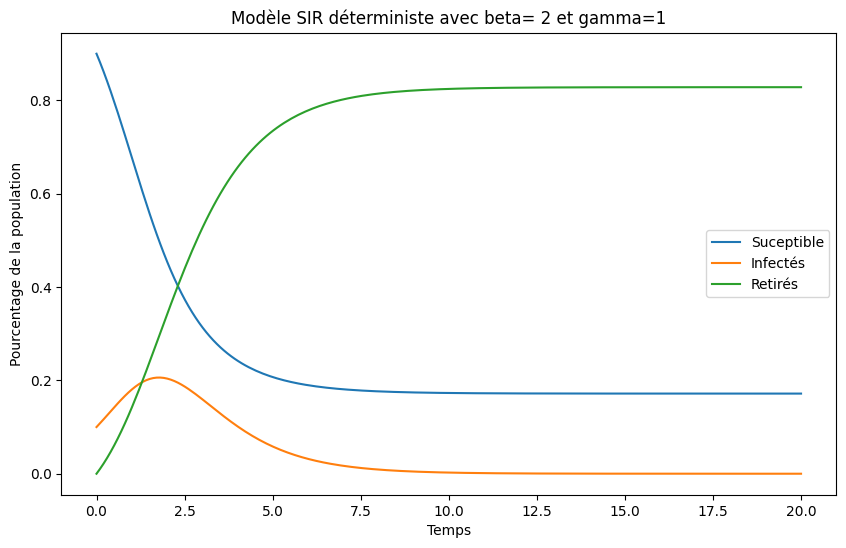

In [109]:
eps = 0.1
beta = 2
gamma = 1
y0 = [1-eps, eps, 0]
temps = np.linspace(0, 20, 20*10)
temps, solution = SIR_deterministe(beta, gamma, temps, y0)
plt.figure(figsize=(10, 6))
plt.plot(temps, solution)
plt.legend(['Suceptible', 'Infectés', 'Retirés'])
plt.xlabel('Temps')
plt.ylabel('Pourcentage de la population')
plt.title('Modèle SIR déterministe avec beta= '+ str(beta) + ' et gamma=' + str(gamma))
plt.show()


## Modele SIR Markov

In [83]:
def Markov_SIR(beta, gamma, N, T, y0):
    temps = [0]
    population = [y0]
    while temps[-1] < T and population[-1][1] != 0:
        s, i, r = population[-1]
        taux_infecte = beta*i*s/N
        taux_gueri = i*gamma
        #print("taux_infecte =",taux_infecte , "taux_gueri",taux_gueri, " s=",s, " i=",i, " r=",r)
        taux_total = taux_infecte + taux_gueri
        tps = np.random.exponential(1/taux_total)
        #print("np.rand.exp = ", tps)
        temps.append(temps[-1] + tps)
        x = np.random.rand()
        if x < taux_infecte/taux_total:
            population.append([s-1, i+1, r])
        else:
            population.append([s, i-1, r+1])
    return temps, population

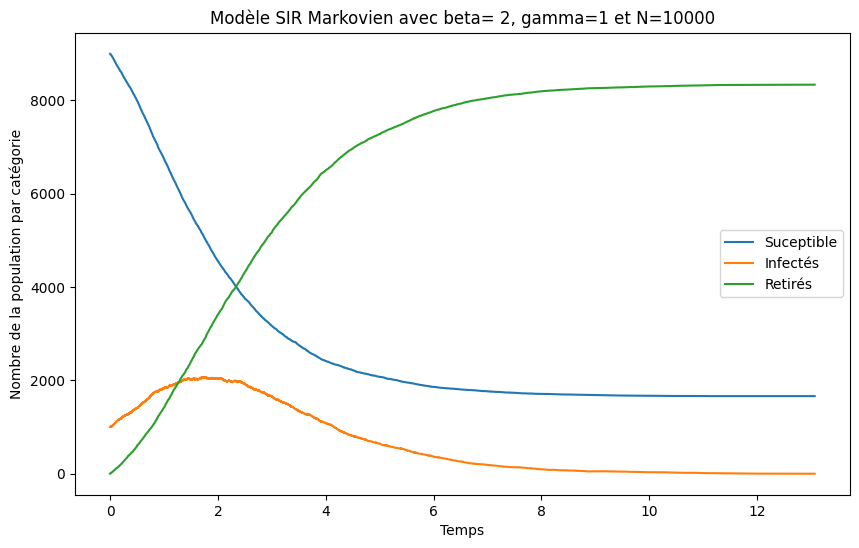

In [129]:
eps = 0.1
beta = 2
gamma = 1
N = 10000
y0 = np.array([1-eps, eps, 0])*N
temps, population = Markov_SIR(beta, gamma, N, 100, y0)
population = np.array(population)
S,I,R = population[:,0], population[:,1], population[:,2]
plt.figure(figsize=(10, 6))
plt.plot(temps, S)
plt.plot(temps, I)
plt.plot(temps, R)
plt.legend(['Suceptible', 'Infectés', 'Retirés'])
plt.xlabel('Temps')
plt.ylabel('Nombre de la population par catégorie')
plt.title('Modèle SIR Markovien avec beta= '+ str(beta) + ', gamma=' + str(gamma) + ' et N=' + str(N))
plt.show()

### Couples $\gamma, \beta$

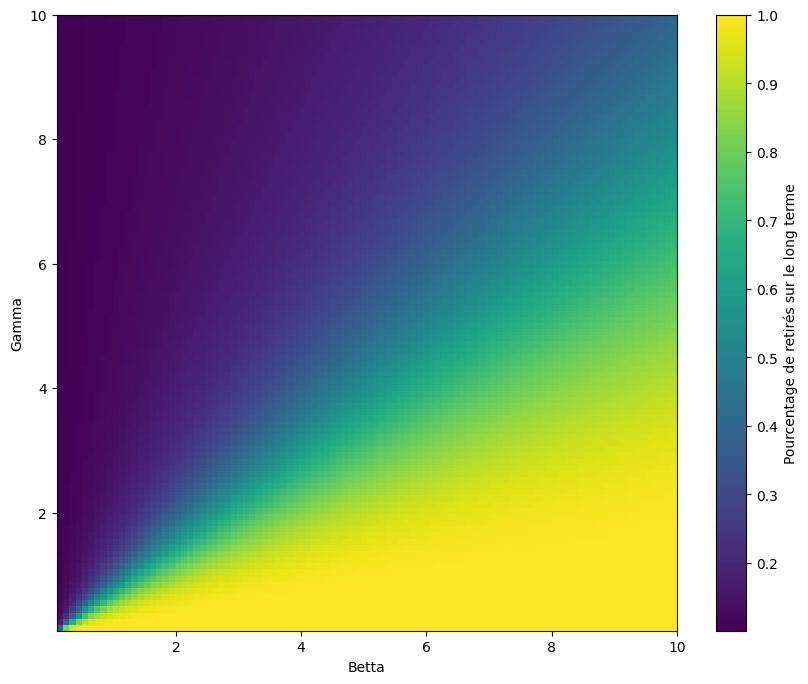

In [110]:
#On fait varier gamma et betta et on regarde l'impact sur la les retirés

eps = 0.1
y0 = [1-eps, eps, 0]
temps = np.linspace(0, 200, 200*10)
gamma_values = np.linspace(0.1, 10, 100)
betta_values = np.linspace(0.1, 10, 100)

heatmap = np.zeros((len(gamma_values), len(betta_values)))

for i, gamma in enumerate(gamma_values):
    for j, betta in enumerate(betta_values):
        r = SIR_deterministe(betta, gamma, temps, y0)[1][:, 2]
        heatmap[i, j] = r[-1]
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, extent=[betta_values[0], betta_values[-1], gamma_values[0], gamma_values[-1]], aspect='auto', origin='lower')
plt.colorbar(label='Pourcentage de retirés sur le long terme')
plt.xlabel('Betta')
plt.ylabel('Gamma')
plt.show()

On remarque que:

-Pour $\beta >> \gamma $ tout le monde est retiré sur le long terme

-Pour $\beta << \gamma $ l'infection n'a pas le temps de se propager et très peu de personnes sont retirés

-Pour $\beta \approx \gamma $ on se retrouve avec un état finale ou une partie de la population a été contaminé

### Convergence processus de Markov

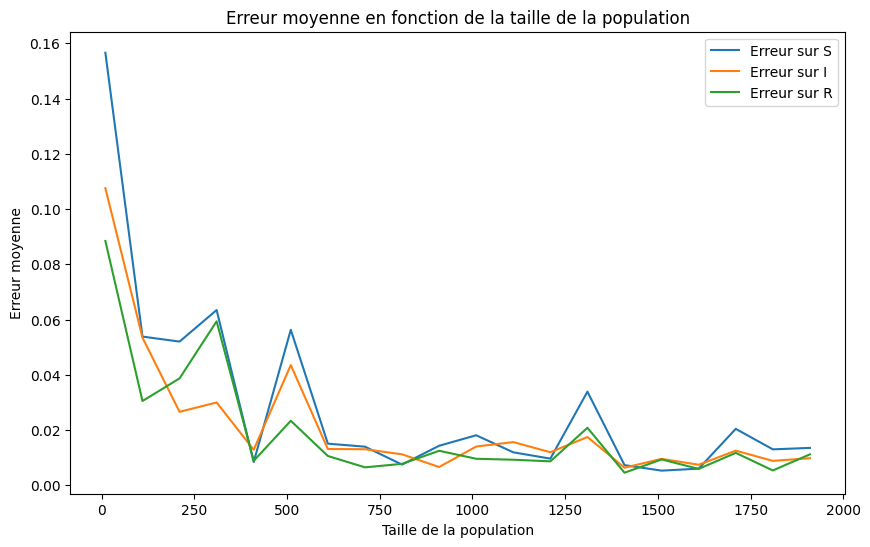

In [142]:
eps = 0.2
beta = 2
gamma = 1
y0 = np.array([1-eps, eps, 0])
Ns = np.arange(10, 2000, 100)
erreur_S = []
erreur_I = []
erreur_R = []
for N in Ns:
    y0_markov = y0*N
    temps, population_markov = Markov_SIR(beta, gamma, N, 100, y0_markov)
    temps, population_deterministe = SIR_deterministe(beta, gamma, temps, y0)
    population_markov = np.array(population_markov)/N
    population_deterministe = np.array(population_deterministe)
    S_markov, I_markov, R_markov = population_markov[:,0], population_markov[:,1], population_markov[:,2]
    S_deterministe, I_deterministe, R_deterministe = population_deterministe[:,0], population_deterministe[:,1], population_deterministe[:,2]
    erreur_S.append((np.abs(S_markov - S_deterministe)).mean())
    erreur_I.append((np.abs(I_markov - I_deterministe)).mean())
    erreur_R.append((np.abs(R_markov - R_deterministe)).mean())

plt.figure(figsize=(10, 6))
plt.plot(Ns, erreur_S)
plt.plot(Ns, erreur_I)
plt.plot(Ns, erreur_R)
plt.legend(['Erreur sur S', 'Erreur sur I', 'Erreur sur R'])
plt.xlabel('Taille de la population')
plt.ylabel('Erreur moyenne')
plt.title('Erreur moyenne en fonction de la taille de la population')
plt.show()


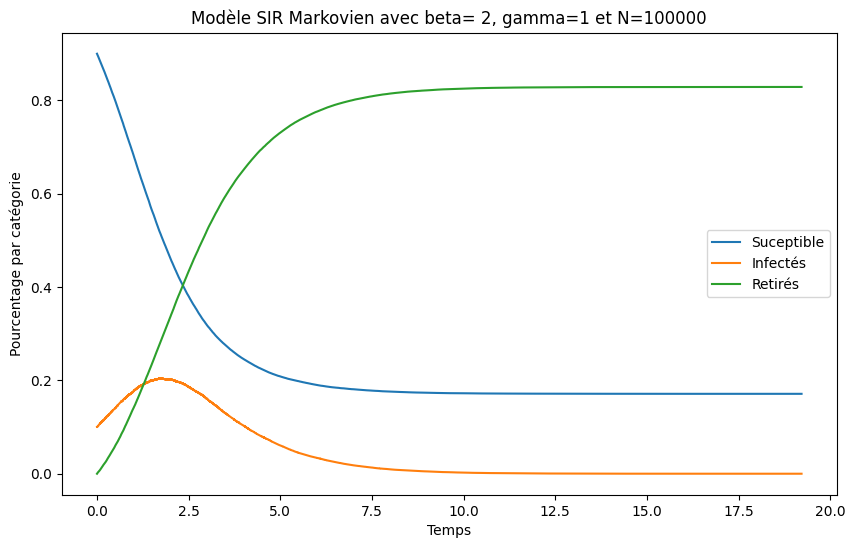

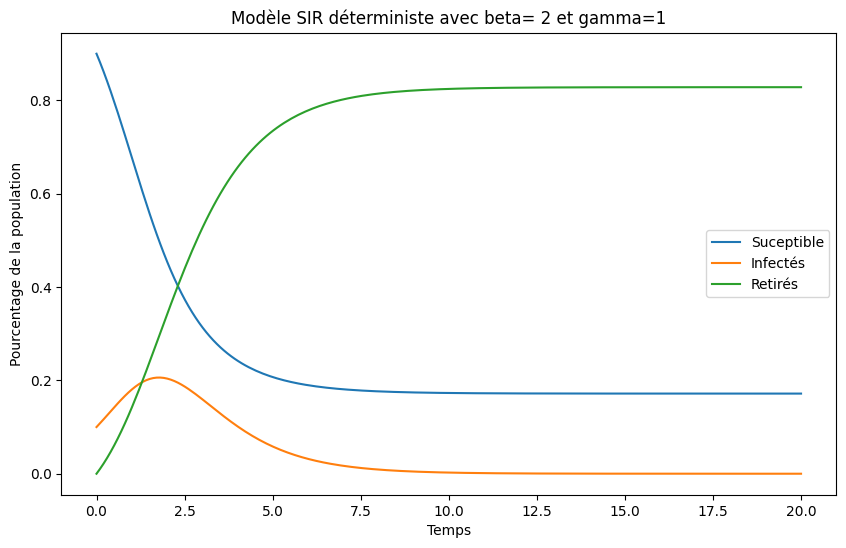

In [146]:
eps = 0.1
beta = 2
gamma = 1
N = 100000
y0 = np.array([1-eps, eps, 0])
y0_mark = y0*N
temps, population = Markov_SIR(beta, gamma, N, 100, y0_mark)
population = np.array(population)/N
S,I,R = population[:,0], population[:,1], population[:,2]
plt.figure(figsize=(10, 6))
plt.plot(temps, S)
plt.plot(temps, I)
plt.plot(temps, R)
plt.legend(['Suceptible', 'Infectés', 'Retirés'])
plt.xlabel('Temps')
plt.ylabel('Pourcentage par catégorie')
plt.title('Modèle SIR Markovien avec beta= '+ str(beta) + ', gamma=' + str(gamma) + ' et N=' + str(N))
plt.show()

temps = np.linspace(0, 20, 20*10)
temps, solution = SIR_deterministe(beta, gamma, temps, y0)
plt.figure(figsize=(10, 6))
plt.plot(temps, solution)
plt.legend(['Suceptible', 'Infectés', 'Retirés'])
plt.xlabel('Temps')
plt.ylabel('Pourcentage de la population')
plt.title('Modèle SIR déterministe avec beta= '+ str(beta) + ' et gamma=' + str(gamma))
plt.show()

On a bien l'erreur qui baisse quand $N$ augmente.

De plus pour $N$ vraiment grand, on remarque que les deux approches donnent des graphiques presqu'identique. Ce qui prouve la convergence du processus de Markov renormalisé vers la solution du système déterministe.

### Question ouverte

Il faut se ramener au modèle SIR,
$N$ est le nombre d'habitant dans le département,
Avec les données du fichier csv on peut faire approximer la dérivées de $S(t), I(t), R(T)$.

En effet on l'évolution en par jour.

On fait alors l'hypothèse:

$S'(t) = -hosp(t)+rea(t) \\
I'(t) =  hosp(t)+rea(t)-dc(t) + rad(t) \\
R'(t) =  dc(t) + rad(t)$

On integre ensuite ces fonctions avec $(N- \epsilon, \epsilon, 0)$ comme condition initiale.

Une fois qu'on a intégrer on a alors les 3 fonctions du modèle SIR et ces dérivées. On peut alors utiliser les équations du modèles SIR pour trouver $\beta$ et $\gamma$.

$\left\{\begin{aligned}
& \frac{dS}{dt} = - \beta I S, \\[6pt]
& \frac{dI}{dt} = \beta I S- \gamma I, \\[6pt]
& \frac{dR}{dt} = \gamma I,
\end{aligned}\right. \quad :(E)$ 

Avec ces équations on a alors : 
$$ \gamma = \frac{\sum_t{\frac{R'(t)}{I(t)}}}{T} \quad \beta = -\frac{\sum_t{\frac{S'(t)}{S(t)I(t)}}}{T} $$

avec $T$ qui est égale au nombre de jour sur lesquels on a pris nos données. Pour trouver $\gamma$ et $\beta$ l'équation $(E)$ étant vrai pour tout $t$ on va prendre la moyenne sur tout les $t$ pour avoir la meilleur approximation.